# Intro to gragh convolutional surrogate models
Eamon Whalen and Azariah Beyene

{Insert Description}

In [1]:
import sys
import numpy as np
import math
import pandas as pd
import altair as alt
import torch
import matplotlib.pyplot as plt 
import torch_geometric as tg 
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D

sys.path.append('./models')
from feastnetSurrogateModel import FeaStNet

sys.path.append('./readers')
from loadGhGraphs import loadGhGraphs

sys.path.append('./visualization')
from altTrussViz import plotTruss, interactiveErrorPlot

sys.path.append('./util')
from gcnSurrogateUtil import *

## 1. Train and perdict deformed trusses

### 1.1 Load simulation data

In [2]:
doeFile = "/Users/Azu/Downloads/2D_Truss_v1.3/design_7_N_1000.csv" 

allGraphsUnfiltered = loadGhGraphs(doeFile, NUM_DV=5)

maxes = [max(np.abs(graph.y.numpy().flatten())) for graph in allGraphsUnfiltered]
source = pd.DataFrame(maxes, columns=['maxes'])
source.describe()

,maxes
count,1000.000000
mean,0.199516
std,2.524026
min,0.006570
25%,0.015425
50%,0.024334
75%,0.046981
max,67.325867


In [3]:
#Truss before and after being deformed by a force
plotTruss(allGraphsUnfiltered[0], showDeformed=True, defScale=100)

alt.LayerChart(...)

### 1.2 Filter and partition

In [4]:
allGraphs = filterbyDisp(allGraphsUnfiltered, 0.9)
trainData, valData, testData = partitionGraphList(allGraphs)

maxes = [max(np.abs(graph.y.numpy().flatten())) for graph in allGraphs]
source = pd.DataFrame(maxes, columns=['maxes'])
source.describe()

,maxes
count,900.000000
mean,0.028952
std,0.019071
min,0.006570
25%,0.014951
50%,0.021719
75%,0.038367
max,0.097861


### 1.3 Train a GCN

In [67]:
#Train New GCN 
gcn = FeaStNet(device=torch.device('cpu'))
history = gcn.trainModel(trainData, valData, 
                     epochs=100, 
                     batch_size=256, 
                     flatten=True, 
                     logTrans=False, 
                     ssTrans=True, 
                     saveDir='./results/gcn10/')

plotHistory(history)

In [5]:
#OR load from previous check point 
gcn = FeaStNet(device=torch.device('cpu'))
gcn.loadModel('./results/gcn09/checkpoint_75')

# gcn = FeaStNet(device=torch.device('cpu'))
# gcn.loadModel('./results/gcn10/checkpoint_91')

### 1.4 Test the GCN

In [6]:
trainRes = gcn.testModel(trainData)
testRes = gcn.testModel(testData)
pd.DataFrame([trainRes, testRes], index=['train', 'test'])

,mse,mae,mre,peakR2,maxAggR2,meanAggR2,minAggR2
train,0.000018,0.002853,0.129876,0.880265,0.943077,0.204593,-11.100102
test,0.000023,0.003039,0.137686,0.782079,0.897531,0.213925,-9.830346


### 1.5 Visualize some predictions

In [7]:
i = 9
pred = gcn.predict([testData[i]])[0]
plotTruss(testData[i], showDeformed=True, defScale=100, prediction=pred)

alt.LayerChart(...)

In [38]:
i = 2
# graph2MaxTriple(testData[0], 3)

newGraph = testData[i].clone() 
newGraph.pos.requires_grad = True 

pred = gcn.predictNew([newGraph])[0]
print(pred)
#plotTruss(testData[i], showDeformed=True, defScale=100, prediction=pred)

tensor([[-0.0089, -0.0157],
        [-0.0051, -0.0109],
        [-0.0082, -0.0071],
        [-0.0017, -0.0013],
        [-0.0033, -0.0052],
        [-0.0033, -0.0102],
        [-0.0031, -0.0137],
        [-0.0020, -0.0151],
        [-0.0013, -0.0141],
        [-0.0022, -0.0108],
        [-0.0048, -0.0049],
        [-0.0069, -0.0009],
        [-0.0025, -0.0040],
        [-0.0052, -0.0075],
        [-0.0035, -0.0104]], dtype=torch.float64, grad_fn=<AddBackward0>)


In [39]:
maxDisp = ((pred**2).sum(axis=1)**(1/2)).max()

maxDisp.backward(retain_graph=True)
print(newGraph.pos.grad)

tensor([[ 6.3185e-03, -4.9433e-03],
        [ 5.5722e-03, -1.6317e-03],
        [ 5.2719e-03, -3.9034e-03],
        [ 4.6329e-03,  2.3903e-03],
        [-9.4823e-04,  8.3947e-04],
        [ 9.9384e-04, -2.1447e-03],
        [-1.0422e-03,  1.0742e-03],
        [ 2.0250e-05, -8.4738e-04],
        [ 4.1396e-04, -3.5456e-04],
        [ 4.1743e-05, -2.3457e-04],
        [ 4.7181e-05, -1.6558e-05],
        [-4.5896e-05,  7.9607e-06],
        [-5.7092e-06,  5.5843e-06],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]])


In [8]:
# interactive scatter plot
alt.data_transformers.enable('json')
allPreds = gcn.predict(testData)
display(interactiveErrorPlot(testData, allPreds))
alt.data_transformers.enable('default');

alt.HConcatChart(...)

## 2. Maximum Displacement and Perturbing Truss Joints

In previous section, we used GCN's to predict truss deformations, but we can take this a step further by giving designers the ability to know how the maximum joint displacement of a truss is affected by perturbing selected joints.

## {eliminate this section}

In [21]:
#TODO: MOVE THESE TO IMPORTED FILE

def mag(x1, y1):
    return (x1**2+y1**2)**(1/2)
    
def generatePerturbedGraphs(og_graph, joint, perturbNum=1.5):
    #takes graph and joint number and outputs list of 255 graphs 
    graphList = [] 
    count = 0 
    dict_disp_to_index = {}
    
    klist = list(np.linspace(-perturbNum, perturbNum, 15))
    for i in klist:
        for j in klist:
            graph = og_graph.clone()
            
            graph.pos[joint, 0] += i
            graph.pos[joint, 1] += j
            graphList.append(graph)
            dict_disp_to_index[(i,j)] = count 
            count+=1
            
    return graphList, dict_disp_to_index 
    
def pred2tripleDisp (pred, tup):
    #takes a numpy array of predicted displacements [x, y, z]; outputs list of (x, y, dist) for max 
    max_disp = 0 
    max_index = 0 
    for i in range(pred.shape[0]):
        current_disp = mag(pred[i, 0], pred[i, 1]) 
        if current_disp>max_disp:
            max_disp = current_disp
            max_index = i 
    return [tup[0], tup[1], max_disp]

def graph2tripleDisp(graph1, joint, perturbGraphGenerator=generatePerturbedGraphs):
    #Select first test graph and first joint; get associated list 
    perturbedGraphList, dict_disp_to_index = perturbGraphGenerator(graph1, joint)
    
    #predict 
    triplesList = [] 
    perturbedGraphListDisp = gcn.predict(perturbedGraphList)  
    
    #build triplesList 
    for tup in dict_disp_to_index.keys():
        index = dict_disp_to_index[tup]
        triple = pred2tripleDisp (perturbedGraphListDisp[index], tup)
        triplesList.append(triple) 
    
    return triplesList 


def graph2MaxTriple(graph1, joint, perturbGraphGenerator=generatePerturbedGraphs):
    #Select first test graph and first joint; get associated list 
    perturbedGraphList, dict_disp_to_index = perturbGraphGenerator(graph1, joint)
    
    #predict 
    triplesList = [] 
    perturbedGraphListDisp = gcn.predict(perturbedGraphList)  
    
    max_disp = 0
    max_triple = [0, 0, 0]
    #build triplesList 
    for tup in dict_disp_to_index.keys():
        index = dict_disp_to_index[tup]
        triple = pred2tripleDisp (perturbedGraphListDisp[index], tup)
        if triple[2]>=max_disp:
            max_triple = triple
            max_disp = triple[2]
        triplesList.append(triple) 
    
    return triplesList, max_triple 

### 2.1 Perturbing Truss Joint

In [11]:
#plot truss
plotTruss(testData[0], showDeformed=False, defScale=100) 

alt.LayerChart(...)

In [12]:
#plot one perturbed truss 
perturbedGraphList = generatePerturbedGraphs(testData[0], 9) [0]
plotTruss(perturbedGraphList[0], showDeformed=False, defScale=100)

alt.LayerChart(...)

### 2.2 Visualize Maximum Displacements 

In [13]:
#plot predicted max displacements 

def plotCountour(narray): 
    #narray is shape nx3 and output plot contour 
    x, y, z = narray[:, 0], narray[:,1], narray[:,2]
    ngridx = 100
    ngridy = 100
    npts = x.shape[0]
    
    fig, (ax1) = plt.subplots(nrows=1)
    xi = np.linspace(-1.6, 1.6, ngridx)
    yi = np.linspace(-1.6, 1.6, ngridy)
    
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax1.contour(xi, yi, zi, levels=14, linewidths=0.15, colors='k')
    cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

    fig.colorbar(cntr1, ax=ax1)
    
    ax1.plot(x, y, 'ko', ms=3)
    ax1.set_aspect('equal')
    ax1.set(xlim=(-1.6, 1.6), ylim=(-1.6, 1.6))
    
    #plt.show() 

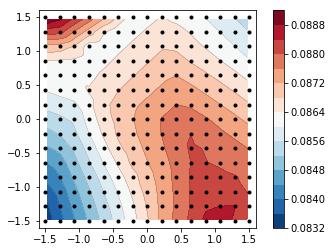

In [14]:
newnptester = np.array(graph2tripleDisp(testData[6], 6))
plotCountour(newnptester)

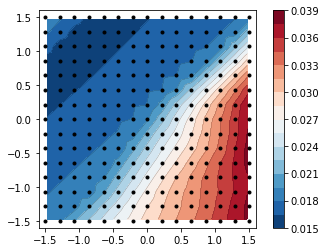

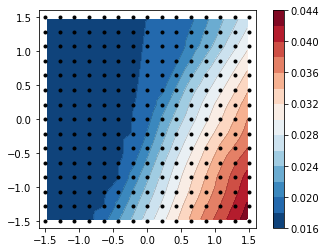

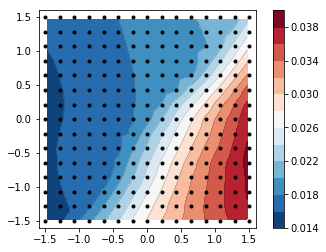

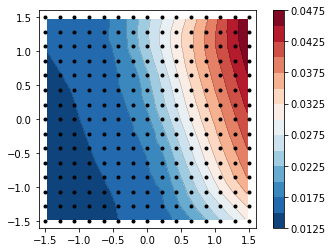

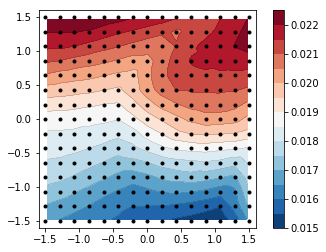

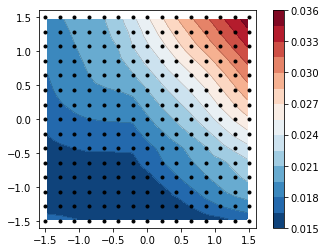

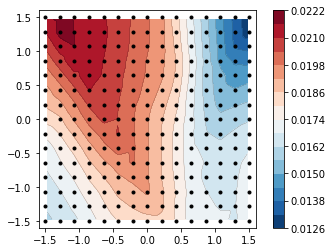

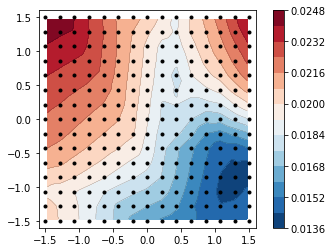

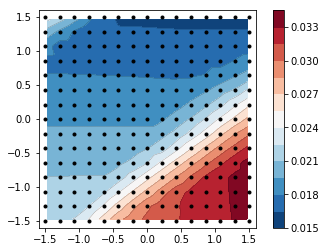

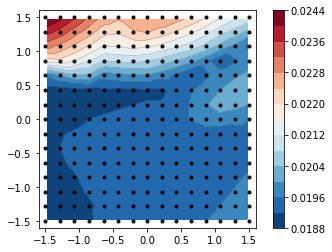

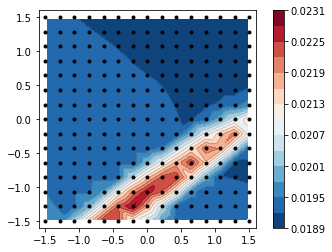

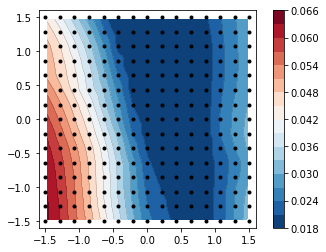

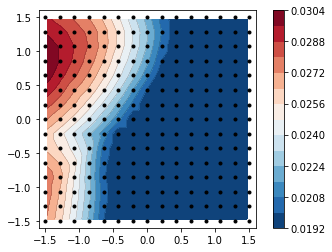

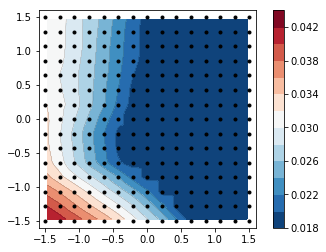

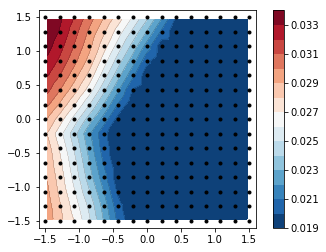

In [81]:
#Plot max displacement as a function of joint displacement 
j = 7
for i in range(15):
    newnptester = np.array(graph2tripleDisp(testData[j], i))
    plotCountour(newnptester)

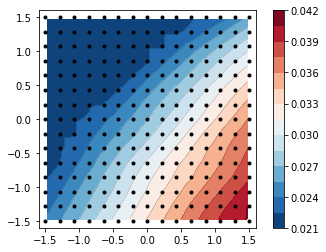

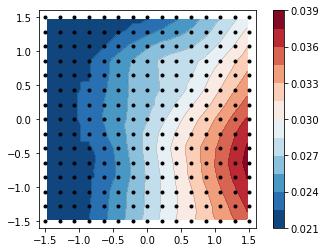

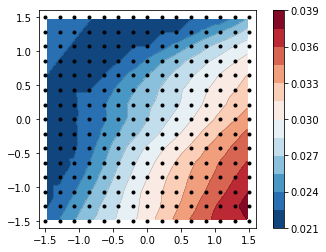

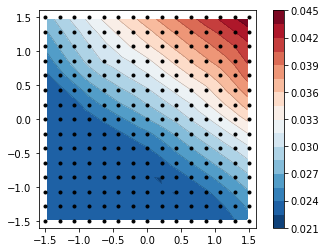

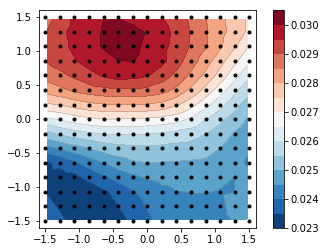

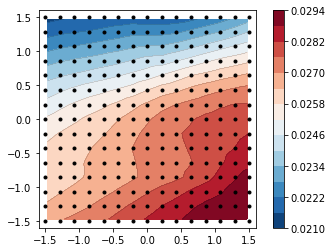

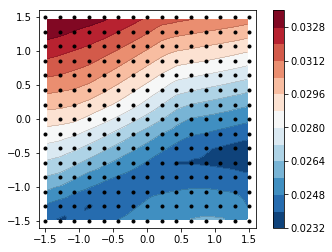

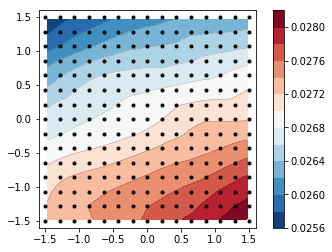

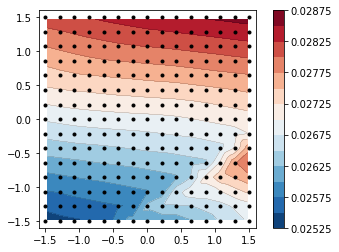

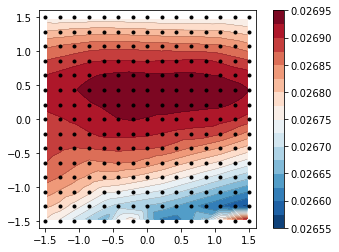

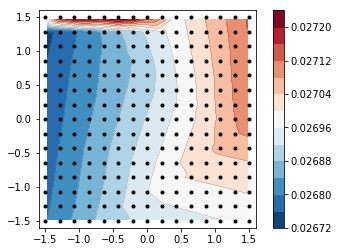

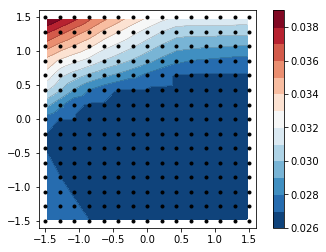

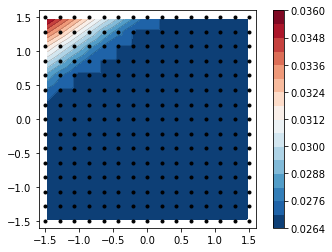

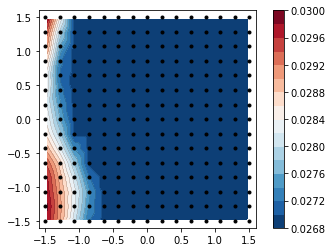

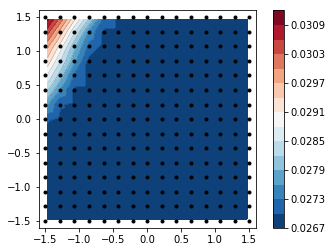

In [82]:
#Plot max displacement as a function of joint displacement 
j = 8
for i in range(15):
    newnptester = np.array(graph2tripleDisp(testData[j], i))
    plotCountour(newnptester)

### 2.3 Direction of maximum discplacement 

Here we will similarly plot the results of perturbing certain joints in certain graphs, but focus on the affect direction has on max discplacement while holding radious constant. 

In [16]:
def getPerturbVector(current_division, division_factor): 
    '''returns unit vector in specified direction '''
    angle_degrees = current_division*division_factor
    angle_radians = math.radians(angle_degrees) 
    return [math.cos(angle_radians), math.sin(angle_radians)]

def generatePerturbGraphsCircle(og_graph, joint_num, radius, division_factor): 
    '''
    input: [graph, int, num, num]
    output: list of perturbed graphs. list is of length [divisions+1]
    '''
    #check if division_factor is valid;
    if abs(int(5*(1/division_factor))-5*(1/division_factor)) >.00001:
        raise Exception('division_factor must be some integer division of 5 i.e. 5/1, 5/2, 5/3, ...')
        
    #loop through all possible divisions and add perturb vector 
    graphList = [] 
    count = 0 
    dict_disp_to_index = {}
    num_divisions = int(365/division_factor)
    
    for i in range(num_divisions):
        graph1 = tg.data.Data(pos = og_graph.pos.clone(),
                             edge_index = og_graph.edge_index.clone(),
                             x = og_graph.x.clone(),
                             y = og_graph.y.clone())
        step_x, step_y = getPerturbVector(i, division_factor) 
        graph1.pos[joint_num, 0] += step_x*radius
        graph1.pos[joint_num, 1] += step_y*radius
        graphList.append(graph1) 
        dict_disp_to_index[(step_x,step_y)] = count 
        count+=1
        
    return graphList, dict_disp_to_index

def graph2tripleCircle(graph1, joint, radius, division_factor, perturbGraphGenerator=generatePerturbGraphsCircle):
    #Select first test graph and first joint; get associated list 
    perturbedGraphList, dict_disp_to_index = perturbGraphGenerator(graph1, joint, radius,division_factor) 
    
    #predict 
    triplesList = [] 
    perturbedGraphListDisp = gcn.predict(perturbedGraphList)  
    
    #build triplesList 
    for tup in dict_disp_to_index.keys():
        index = dict_disp_to_index[tup]
        triple = pred2tripleDisp (perturbedGraphListDisp[index], tup)
        triplesList.append(triple) 
    
    return triplesList, radius  

In [24]:
#circle plotting functions 
def plotCircle(tripleList):
    tripleArray = np.array(tripleList) 
    #create endpoints 
    u = tripleArray[:, 2]*tripleArray[:, 0]
    v = tripleArray[:, 2]*tripleArray[:, 1]
    
    u_min, u_max = u.min(), u.max()
    v_min, v_max = v.min(), v.max()
    print(u_min, u_min, v_min, v_max)
    
    base = [0, 0]
    fig, ax = plt.subplots(1)
    ax.quiver(*base,
               u,
               v, scale=1,
           scale_units='xy',
           angles = 'xy')
    ax.set(xlim=(u_min, u_max), ylim=(v_min, v_max))
    ax.set_aspect('equal')
    #plt.show() 
    
def plotCircleGap(tripleList, radius, scale=1):
    tripleArray = np.array(tripleList)
    
    #create start points 
    x = radius*tripleArray[:, 0]
    y = radius*tripleArray[:, 1]
    
    #create endpoints 
    u = scale*tripleArray[:, 2]*tripleArray[:, 0]
    v = scale*tripleArray[:, 2]*tripleArray[:, 1]
    
    u_min, u_max = x.min()-abs(u.min()), x.max()+abs(u.max())
    v_min, v_max = v.min()-abs(v.min()), v.max()+abs(v.max())
    print(u_min, u_min, v_min, v_max)
    
    fig, ax = plt.subplots(1)
    ax.quiver(x, y,
               u,
               v, scale=1,
           scale_units='xy',
           angles = 'xy')
    ax.set_aspect('equal')
    ax.set(xlim=(-3, 3), ylim=(-3, 3))
    #plt.show() 
    
def plotContourArrow(narray, maxTriple):
    #narray is shape nx3 and output plot contour 
    x, y, z = narray[:, 0], narray[:,1], narray[:,2]
    ngridx = 100
    ngridy = 100
    npts = x.shape[0]
    
    fig, (ax1) = plt.subplots(nrows=1)
    xi = np.linspace(-1.7, 1.7, ngridx)
    yi = np.linspace(-1.7, 1.7, ngridy)
    
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax1.contour(xi, yi, zi, levels=14, linewidths=0.15, colors='k')
    cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

    fig.colorbar(cntr1, ax=ax1)
    
    mag1 = (maxTriple[0]**2+maxTriple[1]**2)**(1/2)
    x1, y1 = maxTriple[0]/mag1, maxTriple[1]/mag1
    
    ax1.quiver([0], [0],
               [x1],
               [y1], scale=1,
           scale_units='xy',
           angles = 'xy')
    
    ax1.plot(x, y, 'ko', ms=3)
    ax1.set_aspect('equal')
    ax1.set(xlim=(-1.7, 1.7), ylim=(-1.7, 1.7))
    #plt.show() 

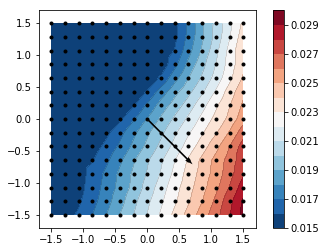

In [40]:
newnptester2, maxTripl = graph2MaxTriple(testData[2], 2)

plotContourArrow(np.array(newnptester2), maxTripl)

146
-0.06529667224750202 -0.06529667224750202 -0.08091970882832286 0.06769929978795755


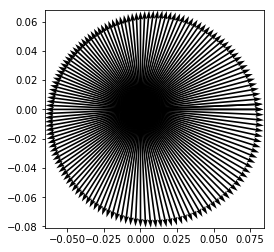

In [34]:
triplesList1, radius1 = graph2tripleCircle(testData[0], 14, 1.5, 2.5) 
print(len(triplesList1))
plotCircle(triplesList1)

## 10. Gradient Direction of maximum discplacement 

In [ ]:
def computeFiniteDiff (narray1, narray2, delta):
    #returns vector of finiteDiff 
    return (1/2*delta)*(narray1-narray2))

def gradPertubDiffCircle(graph, joint_num, radius, division_factor, delta):
    #graph lists of outer and inner 
    outerCircleTripleList, outerRadius = graph2tripleCircle(graph, joint_num, radius+delta, division_factor)
    innerCircleTripleList, innerRadius = graph2tripleCircle(graph, joint_num, radius-delta, division_factor)
    
    